In [1]:
import sys
import os
import torch as th
import cv2

# set the right device
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# NOTE: assuming we are in `ca_body/notebooks`
sys.path.insert(0, '/home/evonneng/audio2photoreal')
from attrdict import AttrDict

from omegaconf import OmegaConf
from torchvision.utils import make_grid

from visualize.ca_body.utils.module_loader import load_from_config
from visualize.ca_body.utils.lbs import LBSModule
from visualize.ca_body.utils.train import load_checkpoint

device = th.device('cuda:0')

In [10]:
# NOTE: make sure to download the data
model_dir = '/home/evonneng/audio2photoreal/checkpoints/ca_body/data/PXB184/'

ckpt_path = f'{model_dir}/body_dec.ckpt'
config_path = f'{model_dir}/config.yml'
assets_path = f'{model_dir}/static_assets.pt'

# config
config = OmegaConf.load(config_path)
# assets
static_assets = AttrDict(th.load(assets_path))
# sample batch
batch = th.load(f'{model_dir}/sample_batch.pt')
batch = {
    key: val.to(device) if th.is_tensor(val) else val
    for key, val in batch.items()
}
# batch = to_device(batch, device)

In [17]:
batch.keys()

dict_keys(['image', 'ao', 'seg_fg', 'seg_part', 'lbs_motion', 'geom', 'face_embs', 'camera_ids', 'campos', 'camrot', 'focal', 'princpt', 'K', 'Rt', '_index', 'face_R', 'face_t'])

In [12]:
# building the model
model = load_from_config(
    config.model, 
    assets=static_assets,
).to(device)

# loading model checkpoint
load_checkpoint(
    ckpt_path, 
    modules={'model': model},
    # NOTE: this is accounting for difference in LBS impl
    ignore_names={'model': ['lbs_fn.*']},
)

[2023-12-21 17:04:11][INFO][visualize.ca_body.utils.geom]:impainting index image might take a while for sizes >= 1024
[2023-12-21 17:04:13][INFO][visualize.ca_body.models.mesh_vae_drivable]:ConvDecoder: n_channels = [64, 32, 16, 8, 4]
[2023-12-21 17:04:14][WARNING][visualize.ca_body.nn.color_cal]:Requested color-calibration identity camera not present, defaulting to 400883.
[2023-12-21 17:04:14][INFO][visualize.ca_body.utils.train]:loading checkpoint /home/evonneng/audio2photoreal/checkpoints/ca_body/data/PXB184//body_dec.ckpt
[2023-12-21 17:04:15][INFO][visualize.ca_body.utils.train]:skipping: ['lbs_fn.*']


In [13]:
# disabling training-only stuff
model.learn_blur_enabled = False
model.pixel_cal_enabled = False
model.cal_enabled = False

# forward
with th.no_grad():
    preds = model(**batch)

[2023-12-21 17:31:18][WARNING][matplotlib.image]:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


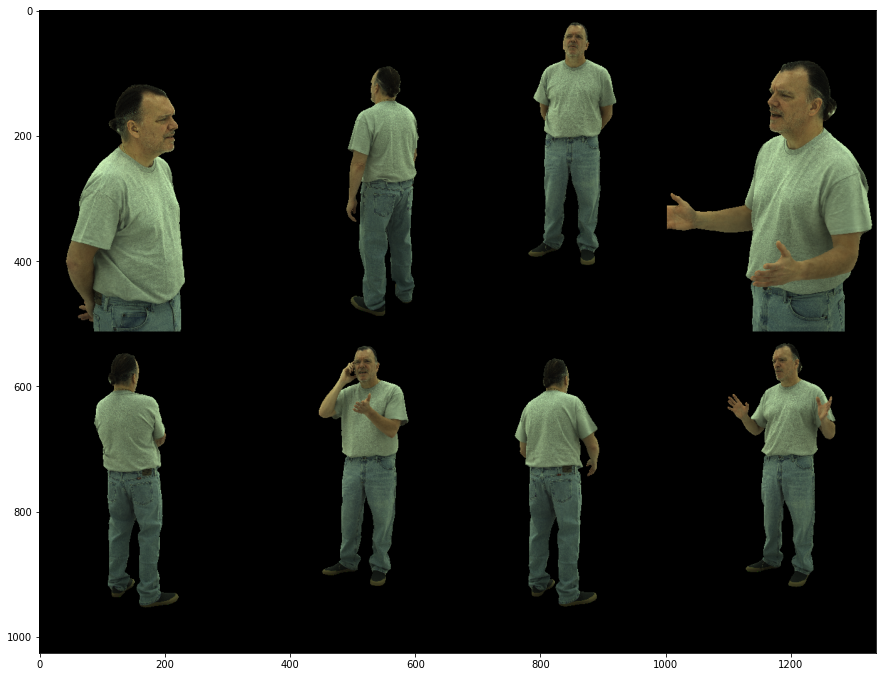

In [16]:
# visualizing
import matplotlib.pyplot as plt
rgb_preds_grid = make_grid(preds['rgb'], nrow=4).permute(1, 2, 0).cpu().numpy() / 255.
plt.figure(figsize=(15, 15))
plt.imshow(rgb_preds_grid[::4,::4])